In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from collections import deque
import random
import torch
import torch.nn as nn
import torch.optim as optim
from abc import ABC, abstractmethod
import gymnasium
import cookiedisaster

In [11]:
envs = [gymnasium.make("cookiedisaster-v1", render_mode="rgb_array"),
        gymnasium.make("cookiedisaster-v2", render_mode="rgb_array"),
        gymnasium.make("cookiedisaster-v3", render_mode="rgb_array")]

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/gymnasium/envs/registration.py:518: DeprecationWarning: WARN: The environment cookiedisaster-v1 is out of date. You should consider upgrading to version `v3`.
  logger.deprecation(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/gymnasium/envs/registration.py:518: DeprecationWarning: WARN: The environment cookiedisaster-v2 is out of date. You should consider upgrading to version `v3`.
  logger.deprecation(


In [12]:
envs[0].reset()
envs[1].reset()
envs[2].reset()
envs[0].step(0)
envs[1].step(0)
envs[2].step(0)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/gymnasium/utils/passive_env_checker.py:133: UserWarning: WARN: The obs returned by the `reset()` method was expecting a numpy array, actual type: <class 'dict'>
  logger.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/gymnasium/spaces/box.py:240: UserWarning: WARN: Casting input x to numpy array.
  gym.logger.warn("Casting input x to numpy array.")
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/gymnasium/utils/passive_env_checker.py:161: UserWarning: WARN: The obs returned by the `reset()` method is not within the observation space.
  logger.warn(f"{pre} is not within the observation space.")
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/gymnasium/utils/passive_env_checker.py:133: UserWarning: WARN: The obs returned by the `step()` method was expecting a numpy array, actual type: <class 'dict'>
  logger.

({'agent': {'pos': 5.8, 'vel': -1.0},
  'cookie': {'pos': 11.29250994405401, 'time': 7}},
 0,
 False,
 False,
 {'distance': 5.492509944054011, 'steps': 1})

In [13]:
env = envs[0]

In [14]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state):
        self.buffer.append((state, action, reward, next_state))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        state, action, reward, next_state = zip(*batch)
        return np.array(state), np.array(action), np.array(reward), np.array(next_state)

    def __len__(self):
        return len(self.buffer)

In [15]:
class DQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, output_dim)
        )

    def forward(self, state):
        return self.network(state)

In [16]:
class DQNAgent:
    def __init__(self, input_dim, action_space, buffer_size=100000, batch_size=64, update_target_every=1000):
        self.policy_net = DQN(input_dim, action_space)
        self.target_net = DQN(input_dim, action_space)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=1e-4)
        self.gamma = 0.99
        self.epsilon = 0.1
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.99
        self.buffer = ReplayBuffer(buffer_size)
        self.batch_size = batch_size
        self.update_target_every = update_target_every
        self.step_count = 0

    def select_action(self, state):
        if np.random.rand() < self.epsilon:
            return np.random.randint(0, self.policy_net.network[-1].out_features)
        else:
            state = torch.FloatTensor([state])
            q_values = self.policy_net(state)
            return torch.argmax(q_values).item()

    def train(self, state, action, reward, next_state):
        self.buffer.push(state, action, reward, next_state)
        if len(self.buffer) < self.batch_size:
            return

        states, actions, rewards, next_states = self.buffer.sample(self.batch_size)
        states = torch.FloatTensor(states)
        next_states = torch.FloatTensor(next_states)
        actions = torch.LongTensor(actions).unsqueeze(1)
        rewards = torch.FloatTensor(rewards)

        current_q = self.policy_net(states).gather(1, actions).squeeze(1)
        next_q = self.target_net(next_states).max(1)[0]
        expected_q = rewards + self.gamma * next_q

        loss = nn.MSELoss()(current_q, expected_q)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        self.step_count += 1
        # periodically update the target network
        if self.step_count % self.update_target_every == 0:
            self.target_net.load_state_dict(self.policy_net.state_dict())

    def save(self):
        torch.save(self.policy_net.state_dict(), "policy_net.pth")
        torch.save(self.target_net.state_dict(), "target_net.pth")

    def load(self):
        self.policy_net.load_state_dict(torch.load("policy_net.pth"))
        self.target_net.load_state_dict(torch.load("target_net.pth"))

In [17]:
def get_features(obs, info):
    agent_pos = obs["agent"]["pos"]
    agent_vel = obs["agent"]["vel"]
    cookie_pos = obs["cookie"]["pos"]
    cookie_time = obs["cookie"]["time"]
    dist = info["distance"]

    return [agent_pos, agent_vel, cookie_pos, cookie_time, dist]

In [18]:
n_observations = len(get_features(*envs[0].reset()))
n_actions = 3

agent = DQNAgent(n_observations, n_actions)
num_episodes = 200
max_steps_per_episode = 1000
rewards = []

for episode in range(num_episodes):
    obs, info = env.reset()
    state = get_features(obs, info)
    total_reward = 0

    for step in range(max_steps_per_episode):
        action = agent.select_action(state)
        next_obs, reward, _, _, next_info = env.step(action)
        next_state = get_features(next_obs, next_info)
        agent.train(state, action, reward, next_state)
        state = next_state
        total_reward += reward

    agent.epsilon = max(agent.epsilon_min, agent.epsilon * agent.epsilon_decay)

    rewards.append(total_reward)
    print(f"\rEpisode: {episode + 1}   Reward: {total_reward:.3f}   Epsilon: {agent.epsilon:.3f}", end="")

Episode: 200   Reward: 130.967   Epsilon: 0.013

In [19]:
cmap = sns.color_palette("magma", n_colors=15)

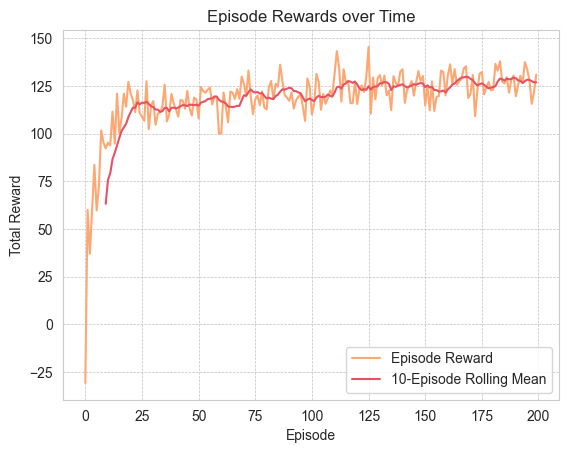

In [20]:
plt.plot(rewards, color=cmap[12], label="Episode Reward")
plt.plot(pd.Series(rewards).rolling(10).mean(), color=cmap[9], label="10-Episode Rolling Mean")
plt.title(f"Episode Rewards over Time")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.grid(color="silver", linestyle='--', linewidth=0.5)
plt.legend()
plt.show()

In [21]:
agent.save()